In [64]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt 
#load data
data_dir = r"C:\Kuliah\ML\foto\foto\train_data"
#Randomize data yang telah di load sekaligus resize menjadi 180 x 180
data = tf.keras.utils.image_dataset_from_directory(data_dir,seed = 123, image_size=(180, 180), batch_size=16)
print(data.class_names)

class_names = data.class_names

img_size = 180
batch = 32
validation_split = 0.1
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images", total_count)
print("Train Images", train_count)
print("Validation Images", val_count)

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)


Found 300 files belonging to 3 classes.
['Matang', 'Mentah', 'Setengah Matang']
Found 300 files belonging to 3 classes.
Total Images 10
Train Images 9
Validation Images 1


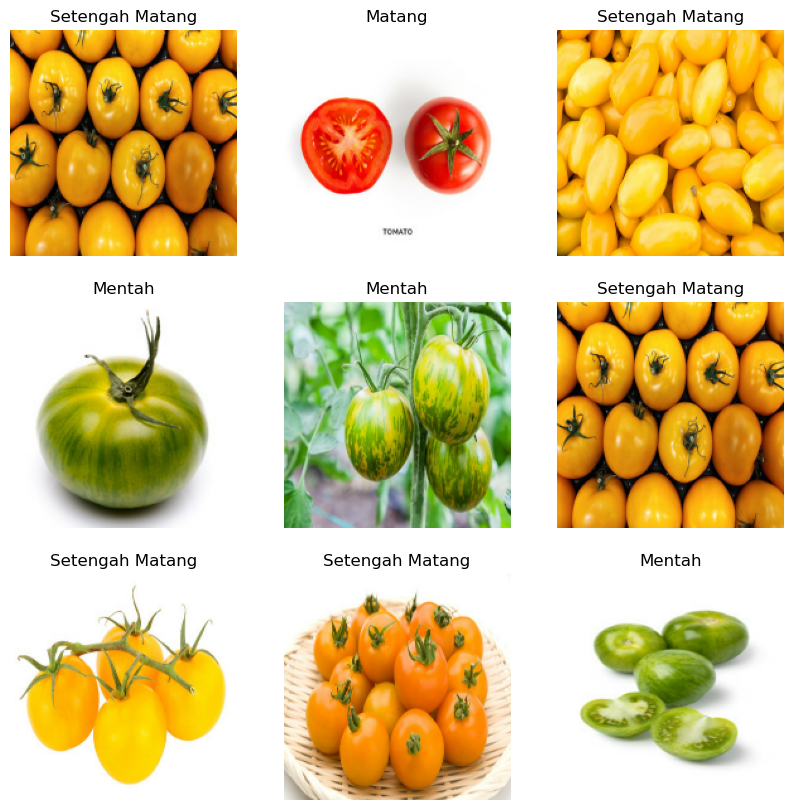

In [65]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

#tampilkan untuk memastikan data sudah di load
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')


In [66]:
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)
    
#loop untuk mengecek atribut gambar(jumlah, tinggi, lebar, dan channel(RGB))

(32, 180, 180, 3)


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


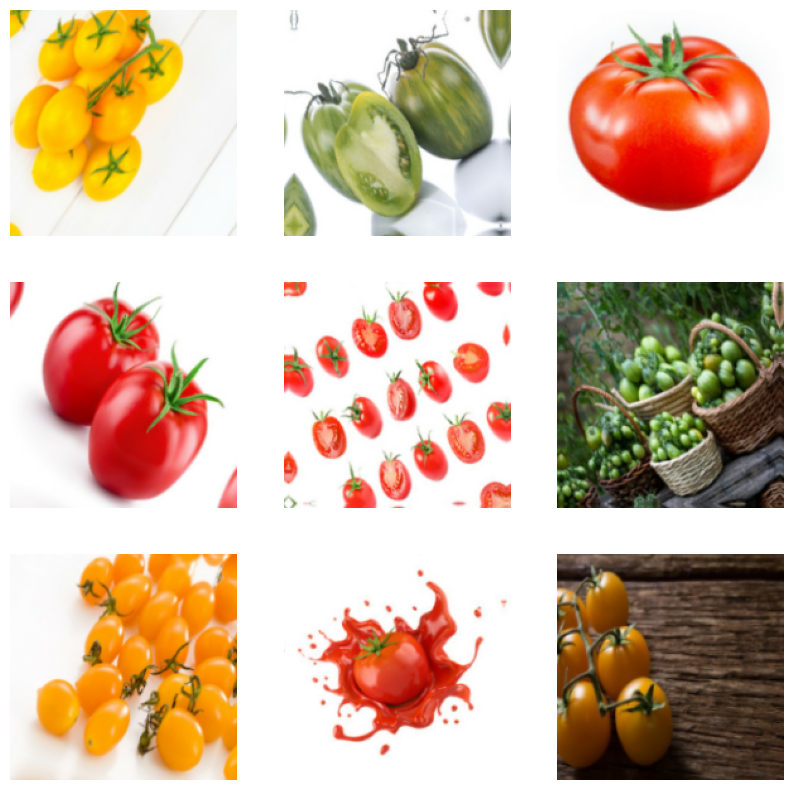

In [67]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt

img_size = 180
batch_size = 32


Tuner = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)
val_ds = val_ds.cache().prefetch(buffer_size = Tuner)

#Augmentasi data dengan menggunakan Sequential
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

i = 0
plt.figure(figsize=(10,10))
#Lihat data setelah di augmentasi
for images, labels in train_ds.take(1):  # Ambil satu batch dari train dataset
    for i in range(9):  # Ambil 9 gambar untuk divisualisasikan
        single_image = images[i]  # Ambil gambar ke-i dari batch
        augmented_image = data_augmentation(tf.expand_dims(single_image, 0))  # Terapkan augmentasi pada gambar tunggal
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))  # Tampilkan gambar
        plt.axis("off")

In [68]:
import tensorflow as tf
import keras

import keras._tf_keras.keras.backend as K
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Conv2D
from keras._tf_keras.keras.layers import Flatten, MaxPool2D, AvgPool2D
from keras._tf_keras.keras.layers import Concatenate, Dropout

from keras._tf_keras.keras.models import load_model

#membuat model from scratch 
def googlenet(input_shape, n_classes):
    
    def inception_block(x, f):
        t1 = Conv2D(f[0], 1, activation='relu')(x)

        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
 
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)

        t4 = MaxPool2D(3, 1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)

        output = Concatenate()([t1, t2, t3, t4])
        return output
  
  
    input = Input(input_shape)
    
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
    
    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])
    
    x = AvgPool2D(3, strides=1)(x)
    x = Dropout(0.4)(x)
  
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
    
    
    model = Model(input, output)
    return model
#Pastikan input shae dan jumlah kelas sesuai 
input_shape = 180, 180, 3   
n_classes = 3             

#Clear Cache Keras menggunakan clear session
K.clear_session()
#buat model dengan 
model = googlenet(input_shape, n_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 22, 22,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 22, 22,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 22, 22,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 22, 22,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 22, 22,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22, 22,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 22, 22,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 22, 22,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                 

 Total params: 6,022,707 (22.97 MB)

 Trainable params: 6,022,707 (22.97 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
#Coimpile dengan optimizer adam
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#buat early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, 
                               mode='max')
#fit validation data ke dalam model
history= model.fit(train_ds, 
                   epochs=30, 
                   validation_data=val_ds, 
                   callbacks=[early_stopping])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 638ms/step - accuracy: 0.3788 - loss: 10.8793 - val_accuracy: 0.4167 - val_loss: 1.0715
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.3365 - loss: 1.1164 - val_accuracy: 0.4167 - val_loss: 1.0826
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 564ms/step - accuracy: 0.3452 - loss: 1.0704 - val_accuracy: 0.5833 - val_loss: 0.8966
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - accuracy: 0.5940 - loss: 0.8707 - val_accuracy: 0.5833 - val_loss: 0.7195
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - accuracy: 0.7368 - loss: 0.6534 - val_accuracy: 0.5833 - val_loss: 0.7278
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - accuracy: 0.6926 - loss: 0.6718 - val_accuracy: 0.6667 - val_loss: 0.5756
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - accuracy: 0.6456 - loss: 0.7199 - val_accuracy: 0.6667 - val_loss: 0.6351
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - accuracy: 0.7053 - loss: 0.5982 - val_accuracy: 0.5833 - val_los

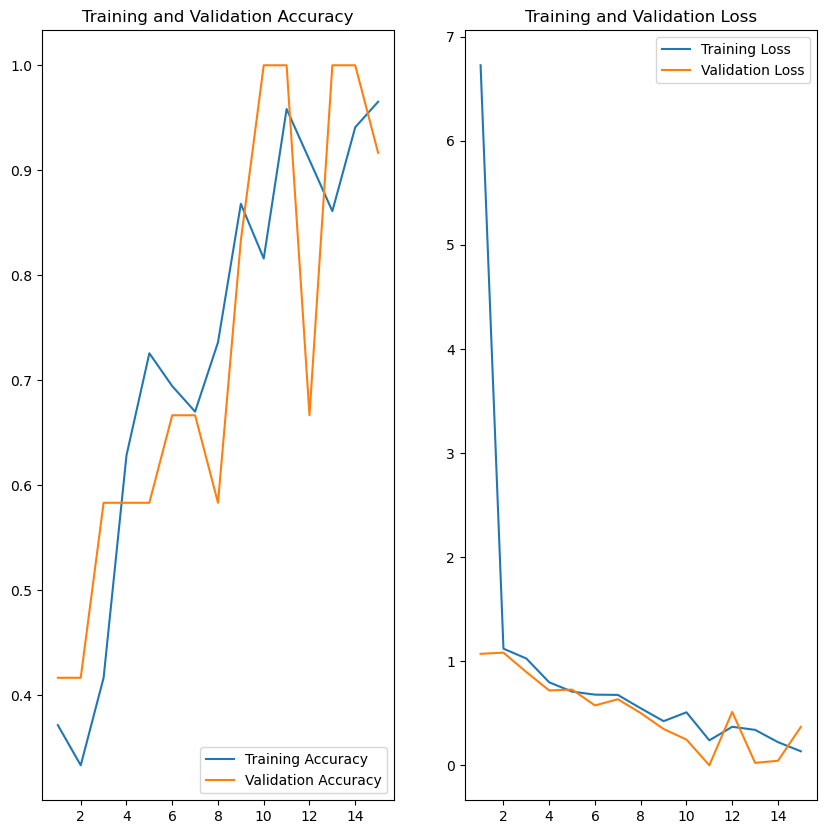

In [70]:
#buat plot dengan menggunakan history supaya jumlahnya sesuai epoch yang dilakukan
ephocs_range = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
model.save('gugelnet.h5')

In [72]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

# Load the trained model
model = load_model(r'C:\Kuliah\ML\Tugas6_B_12068\Tugas6_B_12068\gugelnet.h5')  # Ganti dengan path model Anda
class_names = ['Matang', 'Setengah Matang', 'Mentah']

# Function to classify images and save the original image
def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        # Load and preprocess the image
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  # Add batch dimension

        # Predict
        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        # Display prediction and confidence in notebook
        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        # Save the original image (without text)
        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

# Contoh penggunaan fungsi
result = classify_images(r'C:\Kuliah\ML\foto\foto\test_data\Mentah\hijau-test-1.jpg', save_path='mentah1.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi: Setengah Matang
Confidence: 57.11%
Prediksi: Setengah Matang dengan confidence 57.11%. Gambar asli disimpan di mentah1.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


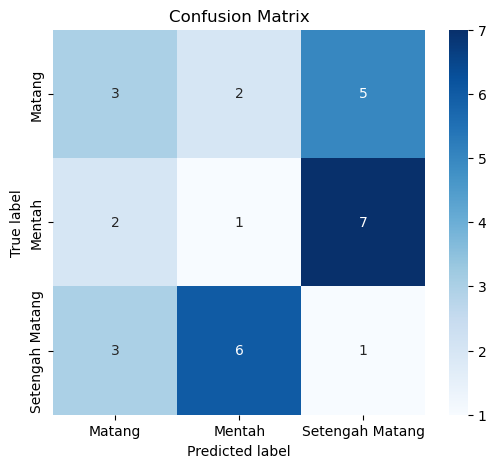

Confusion Matrix:
 [[3 2 5]
 [2 1 7]
 [3 6 1]]
Akurasi:
 0.16666666666666666
Presisi:
 [0.375      0.11111111 0.07692308]
Recall:
 [0.3 0.1 0.1]
F1 Score:
 [0.33333333 0.10526316 0.08695652]


In [82]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

model = load_model(r'C:\Kuliah\ML\Tugas6_B_12068\Tugas6_B_12068\gugelnet.h5')

# Muat data test yang sebenarnya
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Kuliah\ML\foto\foto\test_data',
    labels='inferred',
    label_mode='categorical',  # Pastikan label berupa one-hot encoding
    batch_size=32,
    image_size=(180, 180)
)

# Prediksi model
y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  # Konversi ke kelas prediksi

# Ekstrak label sebenarnya dari test_data dan konversi ke bentuk indeks kelas
true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  # Konversi one-hot ke indeks kelas
true_labels = tf.convert_to_tensor(true_labels)

# Membuat matriks kebingungan
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class, num_classes=len(test_data.class_names))

# Menghitung akurasi
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)


# Menghitung presisi dan recall
precision = tf.math.divide_no_nan(tf.linalg.diag_part(conf_mat), tf.reduce_sum(conf_mat, axis=0))
recall = tf.math.divide_no_nan(tf.linalg.diag_part(conf_mat), tf.reduce_sum(conf_mat, axis=1))

# Menghitung F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:\n", accuracy.numpy())
print("Presisi:\n", precision.numpy())
print("Recall:\n", recall.numpy())
print("F1 Score:\n", f1_score.numpy())
